# American Express - Case Study 

## Part 1 - Data Cleaning

### Part 1 - Importing and Cleaning Data Files

### 1.0 - Import Libraries

In [2]:
import pandas as pd
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb # pip install lightgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import mode

encoder = LabelEncoder()

### 2.0 - Import Files & Clean each dataset

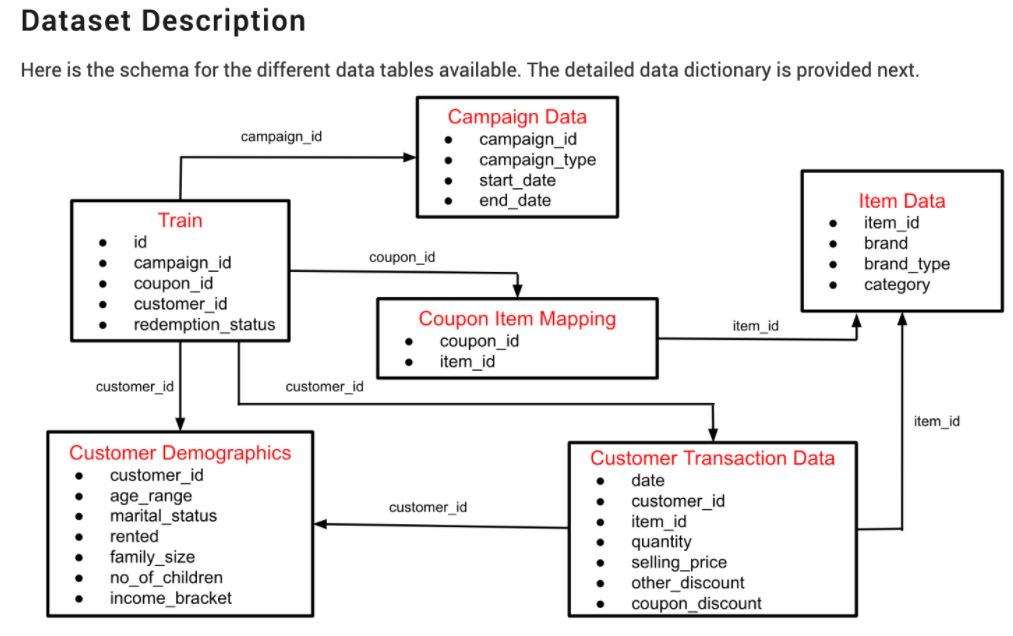

In [81]:
train = pd.read_csv('train.csv')
test =  pd.read_csv('test_QyjYwdj.csv')
coupon_item = pd.read_csv('coupon_item_mapping.csv')
campaign = pd.read_csv('campaign_data.csv')
customer_demo = pd.read_csv('customer_demographics.csv')
customer_trans = pd.read_csv('customer_transaction_data.csv')
items = pd.read_csv('item_data.csv')
sample = pd.read_csv('sample_submission_Byiv0dS.csv')

In [4]:
# TRAIN DATA SET
#------------------
# key column: "Redemption Status"

train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [5]:
test.head()

,id,campaign_id,coupon_id,customer_id
0,3,22,869,967
1,4,20,389,1566
2,5,22,981,510
3,8,25,1069,361
4,10,17,498,811


In [8]:
train.isnull().sum(axis=0),  test.isnull().sum(axis=0)

(id                   0
 campaign_id          0
 coupon_id            0
 customer_id          0
 redemption_status    0
 dtype: int64,
 id             0
 campaign_id    0
 coupon_id      0
 customer_id    0
 dtype: int64)

In [ ]:
# There are no missing values in the train and test set

### 2.1 - Distribution of Redemption status

In [9]:
train['redemption_status'].value_counts('percentage')*100

0    99.069785
1     0.930215
Name: redemption_status, dtype: float64

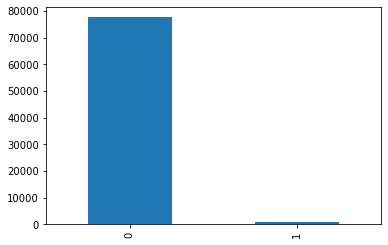

In [10]:
## --- Observation
## imbalanced Dataset
train['redemption_status'].value_counts().plot(kind='bar')

### 3. Cleaning, Preprocessing and Feature Engineering 

### A. Customer Demographics

For this dataset, there is a lot of cleaning of the category levels and transform levels with label endcoder and one hot encoding

In [11]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [12]:
## Observation: Missing values for "Marital Status" and "Number of Children"
customer_demo.isnull().sum(axis=0)

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

In [13]:
# Unique values for No Of Children
# Must update the category for the 3+ category
customer_demo['no_of_children'].unique()

array([nan, '1', '2', '3+'], dtype=object)

In [14]:
# --------  Number of Children - Data Management -------------
# Impute zero for missing values of number of children, as we can expect no value to be no children reported
customer_demo["no_of_children"].fillna(0, inplace=True)

In [15]:
customer_demo['no_of_children'].value_counts()

0     538
1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [16]:
# ----- Number of Children -------
# Fix the 3+ category - 3+ is replaced with 4 kids
customer_demo["no_of_children"] = customer_demo["no_of_children"].apply(lambda x: 4 if x=="3+" else x)

In [17]:
customer_demo["no_of_children"].value_counts()

0    538
1    107
4     60
2     55
Name: no_of_children, dtype: int64

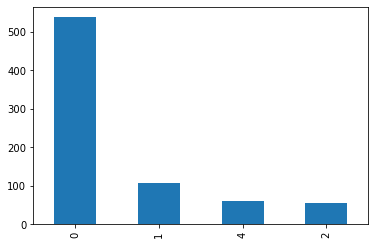

In [25]:
customer_demo['no_of_children'].value_counts().plot(kind='bar')

In [18]:
# Checking the data types. The no_of_children has a string value. Need to convert to numeric
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  760 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [19]:
# Change data type from string to numeric
customer_demo["no_of_children"] =  customer_demo["no_of_children"].astype(np.int64)

In [20]:
# Final table with correct data types. But, we have missing values for "Marital_Status"
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  760 non-null    int64 
 6   income_bracket  760 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 41.7+ KB


In [21]:
# ----- Number of Children -------
# Fix the missing values issues for marital Status
# If Children is reported, then set status to married, if no children, set status to Single.
customer_demo['marital_status'] = customer_demo.apply(lambda x: "Married" if x.no_of_children>0 else "Single", axis=1)

In [22]:
# Final complete table
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  760 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  760 non-null    int64 
 6   income_bracket  760 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 41.7+ KB


In [23]:
customer_demo.marital_status.value_counts()

Single     538
Married    222
Name: marital_status, dtype: int64

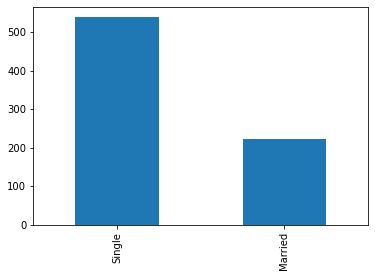

In [24]:
customer_demo['marital_status'].value_counts().plot(kind='bar')

In [26]:
# ----- Family Size -------
customer_demo["family_size"].value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [27]:
# Change the value for 5+ to 6.
customer_demo["family_size"] = customer_demo["family_size"].apply(lambda x: 6 if x=="5+" else x)

In [28]:
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  760 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  760 non-null    int64 
 6   income_bracket  760 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 41.7+ KB


In [29]:
# Convert the data field from string to numeric
customer_demo["family_size"] =  customer_demo["family_size"].astype(np.int64)

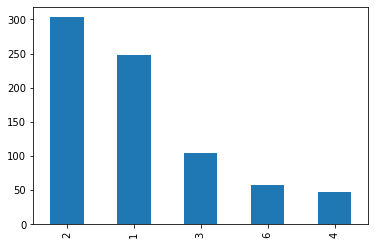

In [31]:
customer_demo['family_size'].value_counts().plot(kind='bar')

In [30]:
# There are two fields which have string format
customer_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  760 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    int64 
 5   no_of_children  760 non-null    int64 
 6   income_bracket  760 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 41.7+ KB


In [32]:
# Apply label endcoder  for the string variables
customer_demo["marital_status"] = encoder.fit_transform(customer_demo["marital_status"])
customer_demo["age_range"] = encoder.fit_transform(customer_demo["age_range"])

In [33]:
# The complete cleaned data set
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,5,1,0,2,0,4
1,6,3,1,0,2,0,5
2,7,1,0,0,3,1,3
3,8,1,0,0,4,2,6
4,10,3,1,0,1,0,5


### B. Campaign Data

For this dataset the campaign duration feature is created by using the dates for start and end for the campaigns. Label encoding for categorical levels.

In [34]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [35]:
# Campaign Type has string type and needs to be converted to numeric. apply label encoder for the two categories
# Start Date  and End Date needs to be converted to date format
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [36]:
campaign["campaign_type"].value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [38]:
# Apply Label Encoder
campaign["campaign_type"] = encoder.fit_transform(campaign.campaign_type)

In [39]:
campaign["start_date"] = pd.to_datetime(campaign["start_date"], dayfirst=True)
campaign["end_date"] = pd.to_datetime(campaign["end_date"], dayfirst=True)

In [40]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,1,2013-10-21,2013-12-20
1,25,1,2013-10-21,2013-11-22
2,20,1,2013-09-07,2013-11-16
3,23,1,2013-10-08,2013-11-15
4,21,1,2013-09-16,2013-10-18


In [41]:
# Feature Engineering: Add a feature for duration of the campaign
campaign["campaign_duration"] = campaign["end_date"] - campaign["start_date"]

In [42]:
campaign.head(1)

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60 days


In [43]:
# Convert to numeric value for days
campaign["campaign_duration"] = campaign["campaign_duration"].apply(lambda x: x.days)

In [44]:
campaign.head(1)

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60


In [45]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   campaign_id        28 non-null     int64         
 1   campaign_type      28 non-null     int64         
 2   start_date         28 non-null     datetime64[ns]
 3   end_date           28 non-null     datetime64[ns]
 4   campaign_duration  28 non-null     int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 1.2 KB


In [46]:
# ---Campaign Start and End Date
campaign_start = min(campaign.start_date)
campaign_end = max(campaign.end_date)

In [48]:
campaign_start, campaign_end

(Timestamp('2012-08-12 00:00:00'), Timestamp('2013-12-20 00:00:00'))

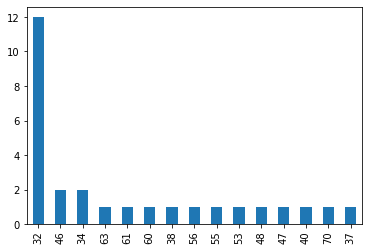

In [50]:
# Most campaigns runs for 32 days
campaign['campaign_duration'].value_counts().plot(kind='bar')

# C. Item Data

In [51]:
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [52]:
# Two categorical features - Convert to numeric
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [56]:
# Nbr of levels in the categorical features
items.brand_type.unique(), items.category.unique()

(array([0, 1]),
 array([ 6,  8,  1, 11, 10, 15,  9,  2, 12, 16,  7, 17,  3,  4, 14,  0,  5,
        13, 18]))

In [53]:
items.brand_type = encoder.fit_transform(items["brand_type"])
items.category = encoder.fit_transform(items["category"])

In [54]:
items.head()

,item_id,brand,brand_type,category
0,1,1,0,6
1,2,1,0,8
2,3,56,1,1
3,4,56,1,6
4,5,56,1,6


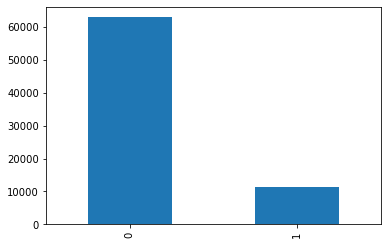

In [58]:
items['brand_type'].value_counts().plot(kind='bar')

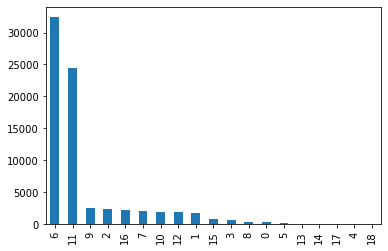

In [57]:
items['category'].value_counts().plot(kind='bar')

## D. Transaction Data

Transaction data for each customer
Feature Engineering: Create a "month" feature

In [82]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [83]:
# The "date" feaures is string formatted, convert it to date
customer_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [84]:
# --> convert the date feature format from string to date
customer_trans["date"] = pd.to_datetime(customer_trans["date"])

In [85]:
customer_trans = customer_trans.sort_values('date')

In [86]:
customer_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324566 entries, 0 to 1322974
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1324566 non-null  datetime64[ns]
 1   customer_id      1324566 non-null  int64         
 2   item_id          1324566 non-null  int64         
 3   quantity         1324566 non-null  int64         
 4   selling_price    1324566 non-null  float64       
 5   other_discount   1324566 non-null  float64       
 6   coupon_discount  1324566 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 80.8 MB


In [87]:
customer_trans = customer_trans.sort_values('date').reset_index(drop=True)

In [88]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,33647,1,67.32,0.00,0.0
2,2012-01-02,1501,48199,1,71.24,-28.14,0.0
3,2012-01-02,1501,57397,1,71.24,-28.14,0.0
4,2012-01-02,857,12424,1,106.50,-14.25,0.0


In [89]:
customer_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   date             1324566 non-null  datetime64[ns]
 1   customer_id      1324566 non-null  int64         
 2   item_id          1324566 non-null  int64         
 3   quantity         1324566 non-null  int64         
 4   selling_price    1324566 non-null  float64       
 5   other_discount   1324566 non-null  float64       
 6   coupon_discount  1324566 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 70.7 MB


In [90]:
# Feature Engineering: Create a new feature "Month"
customer_trans["month"] = customer_trans["date"].apply(lambda x: x.month)

In [98]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,month,coupon_used
0,2012-01-02,1501,26830,1,45.95,-10.69,0.0,1,0
1,2012-01-02,1501,33647,1,67.32,0.00,0.0,1,0
2,2012-01-02,1501,48199,1,99.38,-28.14,0.0,1,0
3,2012-01-02,1501,57397,1,99.38,-28.14,0.0,1,0
4,2012-01-02,857,12424,1,120.75,-14.25,0.0,1,0


In [99]:
# --- Calculate and create "Selling Price" for each item for each customer -- 
customer_trans.selling_price = (customer_trans.selling_price)/(customer_trans.quantity)

In [100]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,month,coupon_used
0,2012-01-02,1501,26830,1,45.95,-10.69,0.0,1,0
1,2012-01-02,1501,33647,1,67.32,0.00,0.0,1,0
2,2012-01-02,1501,48199,1,99.38,-28.14,0.0,1,0
3,2012-01-02,1501,57397,1,99.38,-28.14,0.0,1,0
4,2012-01-02,857,12424,1,120.75,-14.25,0.0,1,0


In [101]:
# --- Calculate and create "other_discount" unit for each item for each customer -- 
customer_trans.other_discount = customer_trans.other_discount/customer_trans.quantity

In [102]:
# --- Re-Calculate and create "Selling Price" unit for each item for each customer taken into account other discounts -- 
customer_trans.selling_price = customer_trans.selling_price - customer_trans.other_discount

In [103]:
# --- Calculate and create "coupon_used" for each item for each customer -- 
# Defined as: If coupon_discount is higher than zero, then set flag = 1, or if not then zero
customer_trans['coupon_used'] = customer_trans.coupon_discount.apply(lambda x: 1 if x !=0 else 0)

In [104]:
customer_trans.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,month,coupon_used
0,2012-01-02,1501,26830,1,56.64,-10.69,0.0,1,0
1,2012-01-02,1501,33647,1,67.32,0.00,0.0,1,0
2,2012-01-02,1501,48199,1,127.52,-28.14,0.0,1,0
3,2012-01-02,1501,57397,1,127.52,-28.14,0.0,1,0
4,2012-01-02,857,12424,1,135.00,-14.25,0.0,1,0


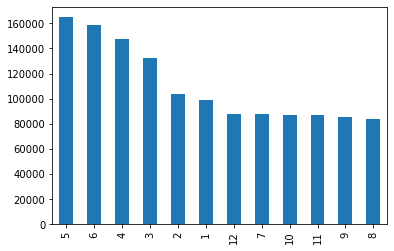

In [105]:
customer_trans['month'].value_counts().plot(kind='bar')

## E. Coupon Item Data

In [75]:
coupon_item.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


## Export DataFiles

In [106]:
coupon_item.to_csv('coupon_item_final.csv', index=False, sep=',')
campaign.to_csv('campaign_final.csv', index=False, sep=',')
customer_demo.to_csv('customer_demo_final.csv', index=False, sep=',')
customer_trans.to_csv('customer_trans_final.csv', index=False, sep=',')
items.to_csv('items_final.csv', index=False, sep=',')
customer_trans.to_csv('customer_trans_final.csv', index=False, sep=',')
coupon_item.to_csv('coupon_item_final.csv', index=False, sep=',')